In [1]:
import myokit
import numpy as np
import matplotlib.pyplot as plt

# Change the font for graphs
plt.rcParams["font.family"] = 'Times New Roman'


In [2]:
# Define the functions needed
def load_model(model):
    m, p, _ = myokit.load(model)
    s = myokit.Simulation(m, p)
    
    # Set the solver tolerance
    s.set_tolerance(1e-10, 1e-10)
    
    # Save the default initial state for the model
    default = s.state()
    return s, default

def simulate(s, default, exp_concs = False, conc_labels = None):
    # Reset the simulation
    s.reset()
    s.set_state(default)
    
    # Set up external concentrations
    if exp_concs:
        Ko = conc_labels[0]
        Nao = conc_labels[1]
        Cao = conc_labels[2]
        s.set_constant(Ko, 4)
        s.set_constant(Nao, 148.35)
        s.set_constant(Cao, 1.8)
        
        # For models with Cl-
        try:
            s.set_constant('extracellular.clo', 143.6)
        except:
            pass
        try:
            s.set_constant('parameters.Clo', 143.6)
        except:
            pass
    
    # Pre-pace for 1500s
    s.pre(1500000)
    
    # Return the outputs
    out = s.run(1000, log_interval = 0.05, log = ['membrane.V'])
    
    return np.array(out['membrane.V'])


# List of the models to use
models = ['Bartolucci_2020', 'Grandi_2010_endo', 'Grandi_Mann_endo', 'ORd_2011_Endo', 'ORd_CiPA', 'ORd_Krogh',
          'ORd_Mann', 'Tomek_2020_Endo', 'TT04', 'TT06_Endo', 'TT06_Mann']
model_labels = ['BPS', 'GPB', 'GPB-M', 'ORd', 'ORd-CiPA', 'ORd-KM', 'ORd-M', 'ToR-ORd', 'TNNP', 'TP', 'TP-M']
concs_labels = [['extracellular.ko', 'extracellular.nao', 'extracellular.cao'],
                ['parameters.Ko', 'parameters.Nao', 'parameters.Cao'],
                ['parameters.Ko', 'parameters.Nao', 'parameters.Cao'],
                ['extracellular.ko', 'extracellular.nao', 'extracellular.cao'],
                ['extracellular.ko', 'extracellular.nao', 'extracellular.cao'],
                ['extracellular.ko', 'extracellular.nao', 'extracellular.cao'],
                ['extracellular.ko', 'extracellular.nao', 'extracellular.cao'],
                ['extracellular.ko', 'extracellular.nao', 'extracellular.cao'],
                ['potassium_dynamics.K_o', 'sodium_dynamics.Na_o', 'calcium_dynamics.Ca_o'],
                ['potassium_dynamics.K_o', 'sodium_dynamics.Na_o', 'calcium_dynamics.Ca_o'],
                ['potassium_dynamics.K_o', 'sodium_dynamics.Na_o', 'calcium_dynamics.Ca_o'],]

# Initialise the variable to store the APs
APs = np.zeros((11, 20000))
APs_exp = np.zeros((11, 20000))

for m, model in enumerate(models):
    # Load the model
    print('\nLoading ' + model + '...')
    s, default = load_model('../MMT models/' + model + '.mmt')
    print('Model successfully loaded')
    
    # Compute the steady-state AP 
    APs[m, :] = simulate(s, default)
    
    # Compute the steady-state AP with eperimental concentrations
    APs_exp[m, :] = simulate(s, default, True, concs_labels[m])



Loading Bartolucci_2020...
Model successfully loaded

Loading Grandi_2010_endo...
Model successfully loaded

Loading Grandi_Mann_endo...
Model successfully loaded

Loading ORd_2011_Endo...
Model successfully loaded

Loading ORd_CiPA...
Model successfully loaded

Loading ORd_Krogh...
Model successfully loaded

Loading ORd_Mann...
Model successfully loaded

Loading Tomek_2020_Endo...
Model successfully loaded

Loading TT04...
Model successfully loaded

Loading TT06_Endo...
Model successfully loaded

Loading TT06_Mann...
Model successfully loaded


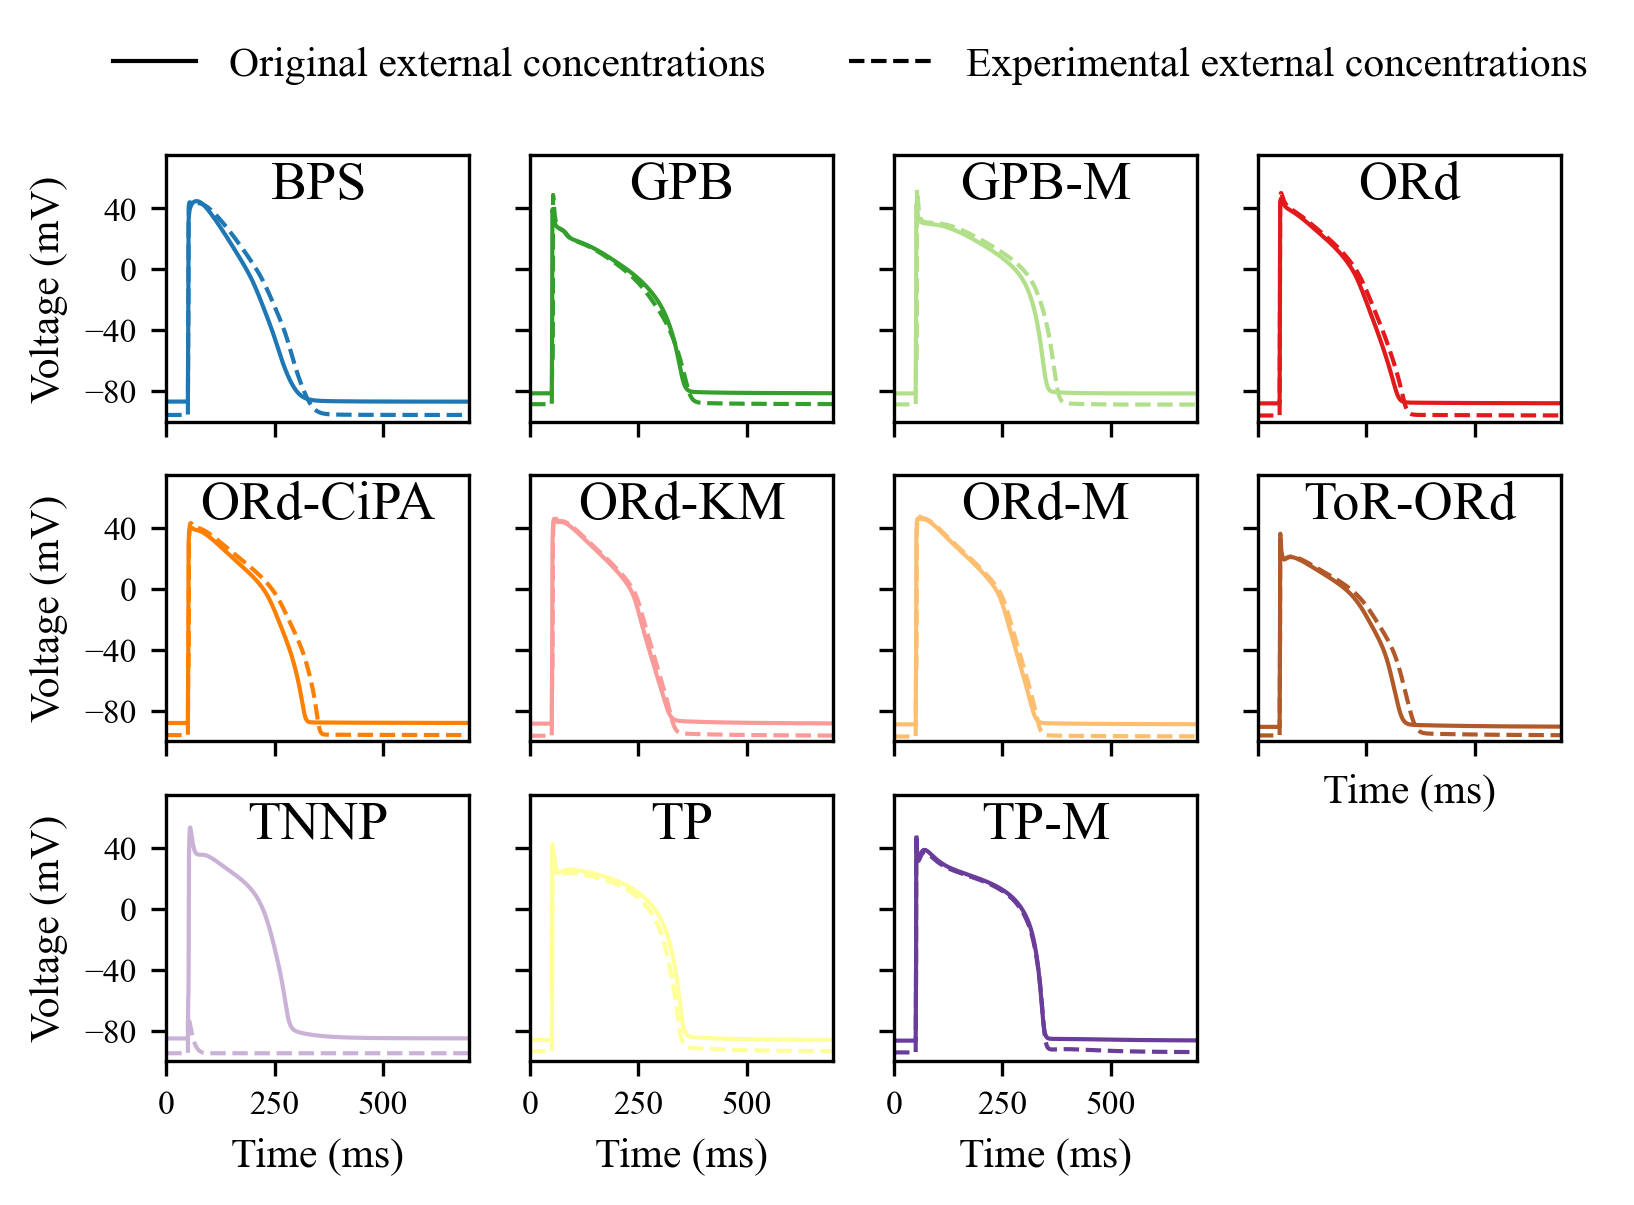

In [4]:
# Plot the APs
fig, axes = plt.subplots(3, 4, figsize = (6, 4), sharex = True, sharey = True)
fig.set_dpi(300)
fig.patch.set_facecolor('white') # Put a white background for the figures

# Plot an AP per subplot
for m, model in enumerate(models):
    # Identify the corresponding subplot
    ax = axes[m // 4, m % 4]
    
    # Plot the AP
    colors = ['#1f78b4','#33a02c','#b2df8a','#e31a1c','#ff7f00','#fb9a99','#fdbf6f','#b15928', '#cab2d6', '#ffff99','#6a3d9a'] # Color palette for dstinguishing the models
    t = np.linspace(0, 999.95, 20000)
    ax.plot(t, APs[m], color = colors[m], linewidth = 1)
    ax.plot(t, APs_exp[m], color = colors[m], linewidth = 1, linestyle = '--')
    
    # Tag the used model
    ax.text(x = 350, y = 55, s = model_labels[m], fontsize = 13, ha = 'center', va = 'center')
    
    # Axes and aesthetics
    ax.set_xlim(0, 700)
    ax.set_ylim(-100, 75)
    ax.set_yticks([-80, -40, 0, 40])
    ax.set_ylabel('Voltage (mV)', fontsize = 10)
    if m % 4 != 0:
    #    ax.set_yticklabels(['', '', '', ''])
        ax.set_ylabel('')
    ax.set_xticks([0, 250, 500])
    ax.tick_params(labelsize = 8)
    ax.set_xlabel('Time (ms)', fontsize = 10)
    if m <= 6:
        ax.set_xlabel('')

# Deactivate the last subplot
axes[-1, -1].axis('off')
# Add the legend
import matplotlib.lines as lines
custom_lines = [lines.Line2D([], [], color = 'k', linewidth = 1, linestyle = '-'), 
                lines.Line2D([], [], color = 'k', linewidth = 1, linestyle = '--'),]

labels = ['Original external concentrations',
          'Experimental external concentrations']

plt.figlegend(custom_lines, labels, edgecolor = 'w', loc='center', fontsize = 10, bbox_to_anchor=(0.5, 0.95, 0.01, 0.01), ncol = 2)

# Save
filename = '1Hz steady-state APs'
plt.savefig(filename + '.png', dpi = 300, bbox_inches = 'tight')
plt.savefig(filename + '.pdf', format = 'pdf', bbox_inches = 'tight')
    